In [ ]:
'''
This is a script to look a basic behavior stats and plot them. Things like hit and correct reject rate,
as well as lick latency.
Created by Yoni Browning, August 2018

'''

In [166]:


%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import datetime 
from datetime import datetime
import scipy.stats
import oBehave.plotting_stuff as obps
import oBehave.helperfunctions as obhf
import oBehave.behavior_analysis as obba
import sklearn.decomposition as decomp


from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.utilities import get_trace_around_timepoint,get_nearest_frame
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

#experiment_id = 639438856
experiment_id = 639253368

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
#dataset= VisualBehaviorOphysDataset(experiment_id=experiment_id, cache_dir=obhf.drive_path)
manifest = obhf.load_manifest()


In [168]:
# Check the manifest, make sure to only include novel sessions
manifest = obhf.load_manifest()
obba.includeNovelSession(manifest)

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date,experiment_datetime,first_session
0,644942849,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,329071,596175193,10/24/2017 10:32,2017-10-24 10:00:32,True
1,645035903,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_B,329071,596175193,10/25/2017 10:34,2017-10-25 10:00:34,True
2,645086795,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_C,329071,596175193,10/26/2017 10:27,2017-10-26 10:00:27,True
3,645362806,644919226,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_D,329071,596175193,10/30/2017 11:41,2017-10-30 11:00:41,True
4,646922970,646555436,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,330982,596393048,11/7/2017 14:19,2017-11-07 14:00:19,True
5,647108734,646555436,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_B,330982,596393048,11/8/2017 11:56,2017-11-08 11:00:56,True
6,647551128,646555436,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_C,330982,596393048,11/9/2017 11:48,2017-11-09 11:00:48,True
7,647887770,646555436,VISp,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_D,330982,596393048,11/10/2017 13:06,2017-11-10 13:00:06,True
8,648647430,648562391,VISal,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_A,330982,596393048,11/15/2017 11:58,2017-11-15 11:00:58,False
9,649118720,648562391,VISal,175,Vip-IRES-Cre,Ai148,Vip-IRES-Cre;Ai148,behavior_session_B,330982,596393048,11/16/2017 11:45,2017-11-16 11:00:45,False


In [81]:
# Get performace data for each mouse on each session
unique_donors = np.unique(manifest.donor_id)
keynames = ['donor_id','A_HIT','B_HIT','C_HIT','D_HIT',
            'A_CR','B_CR','C_CR','D_CR',
            'A_LAT','B_LAT','C_LAT','D_LAT',
            'A_FLAT','B_FLAT','C_FLAT','D_FLAT',
            'cre_line',]
behavior_types = np.unique(manifest.session_type)
cd = {k: [] for k in keynames}
for ii,donor in enumerate(unique_donors):
    thismouse = manifest[manifest.donor_id==donor].sort_values('experiment_datetime',ascending = True)
    cd['donor_id'].append(thismouse.donor_id.values[0])
    cd['cre_line'].append(thismouse.cre_line.values[0])
    for beh in behavior_types:
        if beh in thismouse.session_type.values:
            experiment_id = thismouse[thismouse.session_type==beh]['experiment_id'].values[0]
            print(experiment_id)
            dataset= VisualBehaviorOphysDataset(experiment_id=experiment_id, cache_dir=obhf.drive_path)
            trldata = dataset.trials
            catch_ave = np.mean([trldata[trldata.trial_type=='catch']['response_type']=='CR'])
            go_ave = np.mean([trldata[trldata.trial_type=='go']['response_type']=='HIT'])
            # responce_latencies
            go_resp = trldata[trldata.trial_type=='go']['response_latency'].values
            lat_av_go = np.mean(go_resp[~np.isnan(go_resp)])
            catch_resp = trldata[trldata.trial_type=='catch']['response_latency'].values
            lat_av_catch = np.mean(catch_resp[~np.isnan(catch_resp)])
        else:
            go_ave = np.nan
            catch_ave = np.nan
            go_resp = np.nan
            catch_resp = np.nan
        if 'A' in beh:
            cd['A_HIT'].append(go_ave)
            cd['A_CR'].append(catch_ave)
            cd['A_LAT'].append(lat_av_go)
            cd['A_FLAT'].append(lat_av_catch)

        elif 'B' in beh:
            cd['B_HIT'].append(go_ave)
            cd['B_CR'].append(catch_ave)
            cd['B_LAT'].append(lat_av_go)
            cd['B_FLAT'].append(lat_av_catch)
        elif 'C' in beh:
            cd['C_HIT'].append(go_ave)
            cd['C_CR'].append(catch_ave)
            cd['C_LAT'].append(lat_av_go)
            cd['C_FLAT'].append(lat_av_catch)
        elif 'D' in beh:
            cd['D_HIT'].append(go_ave)
            cd['D_CR'].append(catch_ave)
            cd['D_LAT'].append(lat_av_go)
            cd['D_FLAT'].append(lat_av_catch)
                
behavior_data = pd.DataFrame(cd)

644942849
645035903
645086795
645362806
646922970
647108734
647551128
647887770
652844352
653053906
653123781
639253368
639438856
639769395
639932228
661423848
663771245
663773621
665286182
670396087
671152642
672584839
672185644
695471168
696136550
698244621
698724265
685744008
686726085
692342909
692841424
693272975
693862238
712178916
712860764
713525580
714126693
715228642
715887471
716337289
716602547
719321260
719996589
723748162
723037901


0
1
3
4
5
6
8
9
10
11


Ttest_relResult(statistic=-2.2529812738553208, pvalue=0.050755423207690151)

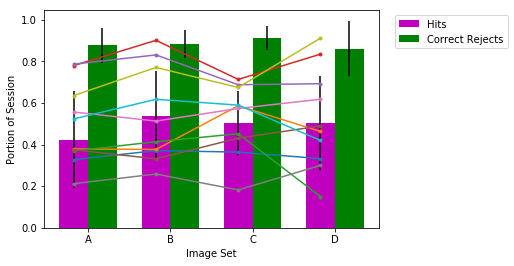

In [80]:
# Plot performace data.
width = .35
fig, ax = plt.subplots()
bd = behavior_data
rects1 = ax.bar([1,2,3,4], [np.mean(bd['A_HIT']),np.mean(bd['B_HIT']),np.mean(bd['C_HIT']),np.mean(bd['D_HIT'])], 
                width, color='m', yerr=[np.std(bd['A_HIT']),np.std(bd['B_HIT']),np.std(bd['C_HIT']),np.std(bd['D_HIT'])])
rects2 = ax.bar(np.array([1,2,3,4])+width, [np.mean(bd['A_CR']),np.mean(bd['B_CR']),np.mean(bd['C_CR']),np.mean(bd['D_CR'])], 
                width, color='g', yerr=[np.std(bd['A_CR']),np.std(bd['B_CR']),np.std(bd['C_CR']),np.std(bd['D_CR'])])
plt.xticks(np.array([1,2,3,4])+width/2.,['A','B','C','D'])
plt.xlabel('Image Set')
plt.ylabel('Portion of Session')
plt.legend(['Hits','Correct Rejects'],loc = 'upper right',bbox_to_anchor=(1.4, 1))

centers = [1,2,3,4]
usedata = np.logical_or(np.isnan(bd['A_HIT']),np.isnan(bd['B_HIT']))
for ii,useme in enumerate(~usedata):
    if useme:
        print(ii)
        plt.plot(centers,[bd['A_HIT'].values[ii],bd['B_HIT'].values[ii],bd['C_HIT'].values[ii],bd['D_HIT'].values[ii]],'.-')
scipy.stats.ttest_rel(bd['A_HIT'][~usedata],bd['B_HIT'][~usedata])


In [ ]:
# older version, copied to bottom to avoid conflicts
keys = ['A_HIT','B_HIT','C_HIT','D_HIT','A_CR','B_CR','C_CR','D_CR']
values = [[],[],[],[],[],[],[],[]]
cd = dict(zip(keys[:],values[:]))

for ii, row in manifest[manifest['cre_line']=='Vip-IRES-Cre'].iterrows():
    dataset = VisualBehaviorOphysDataset(experiment_id = row['experiment_id'], cache_dir=obhf.drive_path)
    trldata = dataset.trials
    catch_ave = np.mean([trldata[trldata.trial_type=='catch']['response_type']=='CR'])
    go_ave = np.mean([trldata[trldata.trial_type=='go']['response_type']=='HIT'])
    
    if 'A' in row.session_type:
        cd['A_HIT'].append(go_ave)
        cd['A_CR'].append(catch_ave)

    elif 'B' in row.session_type:
        cd['B_HIT'].append(go_ave)
        cd['B_CR'].append(catch_ave)

    elif 'C' in row.session_type:
        cd['C_HIT'].append(go_ave)
        cd['C_CR'].append(catch_ave)

    elif 'D' in row.session_type:
        cd['D_HIT'].append(go_ave)
        cd['D_CR'].append(catch_ave)

width = .35
fig, ax = plt.subplots()
rects1 = ax.bar([1,2,3,4], [np.mean(cd['A_HIT']),np.mean(cd['B_HIT']),np.mean(cd['C_HIT']),np.mean(cd['D_HIT'])], 
                width, color='m', yerr=[np.std(cd['A_HIT']),np.std(cd['B_HIT']),np.std(cd['C_HIT']),np.std(cd['D_HIT'])])
rects2 = ax.bar(np.array([1,2,3,4])+width, [np.mean(cd['A_CR']),np.mean(cd['B_CR']),np.mean(cd['C_CR']),np.mean(cd['D_CR'])], 
                width, color='g', yerr=[np.std(cd['A_CR']),np.std(cd['B_CR']),np.std(cd['C_CR']),np.std(cd['D_CR'])])


keys = ['A_HIT','B_HIT','C_HIT','D_HIT','A_CR','B_CR','C_CR','D_CR']
values = [[],[],[],[],[],[],[],[]]
cdlow = dict(zip(keys[:],values[:]))

for ii, row in manifest[manifest['cre_line']=='Vip-IRES-Cre'].iterrows():
    dataset = VisualBehaviorOphysDataset(experiment_id = row['experiment_id'], cache_dir=obhf.drive_path)
    trldata = dataset.trials
    catch_ave = np.mean(np.array(trldata[trldata.trial_type=='catch']['response_type']=='CR')[:25])
    go_ave = np.mean(np.array(trldata[trldata.trial_type=='go']['response_type']=='HIT')[:25])
    if 'A' in row.session_type:
        cdlow['A_HIT'].append(go_ave)
        cdlow['A_CR'].append(catch_ave)

    elif 'B' in row.session_type:
        cdlow['B_HIT'].append(go_ave)
        cdlow['B_CR'].append(catch_ave)

    elif 'C' in row.session_type:
        cdlow['C_HIT'].append(go_ave)
        cdlow['C_CR'].append(catch_ave)

    elif 'D' in row.session_type:
        cdlow['D_HIT'].append(go_ave)
        cdlow['D_CR'].append(catch_ave)
width = .35
fig, ax = plt.subplots()
rects1 = ax.bar([1,2,3,4], [np.mean(cdlow['A_HIT']),np.mean(cdlow['B_HIT']),np.mean(cdlow['C_HIT']),np.mean(cdlow['D_HIT'])], 
                width, color='m', yerr=[np.std(cdlow['A_HIT']),np.std(cdlow['B_HIT']),np.std(cdlow['C_HIT']),np.std(cdlow['D_HIT'])])
rects2 = ax.bar(np.array([1,2,3,4])+width, [np.mean(cdlow['A_CR']),np.mean(cdlow['B_CR']),np.mean(cdlow['C_CR']),np.mean(cdlow['D_CR'])], 
                width, color='g', yerr=[np.std(cdlow['A_CR']),np.std(cdlow['B_CR']),np.std(cdlow['C_CR']),np.std(cdlow['D_CR'])])

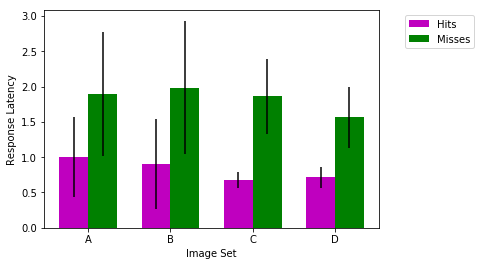

In [87]:
# Plot response latencies 
width = .35
fig, ax = plt.subplots()
bd = behavior_data
rects1 = ax.bar([1,2,3,4], [np.mean(bd['A_LAT']),np.mean(bd['B_LAT']),np.mean(bd['C_LAT']),np.mean(bd['D_LAT'])], 
                width, color='m', yerr=[np.std(bd['A_LAT']),np.std(bd['B_LAT']),np.std(bd['C_LAT']),np.std(bd['D_LAT'])])
rects2 = ax.bar(np.array([1,2,3,4])+width, [np.mean(bd['A_FLAT']),np.mean(bd['B_FLAT']),np.mean(bd['C_FLAT']),np.mean(bd['D_FLAT'])], 
                width, color='g', yerr=[np.std(bd['A_FLAT']),np.std(bd['B_FLAT']),np.std(bd['C_FLAT']),np.std(bd['D_FLAT'])])
plt.xticks(np.array([1,2,3,4])+width/2.,['A','B','C','D'])
plt.xlabel('Image Set')
plt.ylabel('Response Latency')
plt.legend(['Hits','Misses'],loc = 'upper right',bbox_to_anchor=(1.3, 1))


# centers = [1,2,3,4]
# usedata = np.logical_or(np.isnan(bd['A_LAT']),np.isnan(bd['B_LAT']))
# for ii,useme in enumerate(~usedata):
#     if useme:
#         print(ii)
#         plt.plot(centers,[bd['A_LAT'].values[ii],bd['B_LAT'].values[ii],bd['C_LAT'].values[ii],bd['D_LAT'].values[ii]],'.-')
# scipy.stats.ttest_rel(bd['A_LAT'][~usedata],bd['B_LAT'][~usedata])
